In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from pennylane.optimize import SPSAOptimizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
np.random.seed(42)

In [3]:
num_qubits = 2
delta = 0.3
num_samples = 100

In [4]:
def phi(x):
    return [x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])]

In [5]:
def random_su4():
    return unitary_group.rvs(4)

In [6]:
Z1Z2 = np.kron([[1, 0], [0, -1]], [[1, 0], [0, -1]])

In [7]:
dev = qml.device("default.qubit", wires=2)

In [8]:
def feature_map(x):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(x[0], wires=0)
    qml.RZ(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(x[2], wires=1)
    qml.CNOT(wires=[0, 1])

In [9]:
V_matrix = random_su4()

In [10]:
@qml.qnode(dev)
def label_qnode(x):
    feature_map(phi(x))
    qml.QubitUnitary(V_matrix.conj().T, wires=[0, 1])
    return qml.expval(qml.Hermitian(Z1Z2, wires=[0, 1]))

In [11]:
X_data, Y_labels = [], []

while len(X_data) < 2 * num_samples:
    x = 2 * np.pi * np.random.rand(2)
    expectation = label_qnode(x)
    if expectation >= delta:
        Y_labels.append(1)
        X_data.append(x)
    elif expectation <= -delta:
        Y_labels.append(-1)
        X_data.append(x)

In [12]:
X_data = np.array(X_data)
Y_labels = np.array(Y_labels)

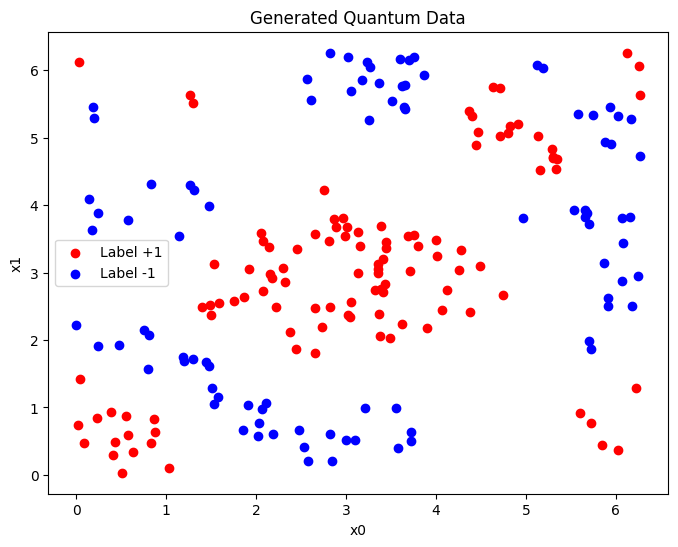

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(X_data[Y_labels == 1][:, 0], X_data[Y_labels == 1][:, 1], color='red', label='Label +1')
plt.scatter(X_data[Y_labels == -1][:, 0], X_data[Y_labels == -1][:, 1], color='blue', label='Label -1')
plt.title("Generated Quantum Data")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_labels, test_size=0.3, random_state=42)

In [15]:
def variational_block(weights):
    for i in range(num_qubits):
        qml.RX(weights[i][0], wires=i)
        qml.RY(weights[i][1], wires=i)
    qml.CZ(wires=[0, 1])

In [16]:
obs = qml.PauliZ(0) @ qml.PauliZ(1)

In [17]:
@qml.qnode(dev)
def vqc(x, weights):
    feature_map(phi(x))
    variational_block(weights)
    return qml.expval(obs)

In [18]:
def cost_train(weights):
    loss = 0
    for x, y in zip(X_train, y_train):
        pred = vqc(x, weights)
        loss += (y - pred)**2
    return loss / len(y_train)

In [19]:
weights = 0.01 * np.random.randn(num_qubits, 2, requires_grad=True)

In [20]:
weights = 0.01 * np.random.randn(num_qubits, 2, requires_grad=True)
opt = SPSAOptimizer(maxiter=250)
for i in range(500):
    weights = opt.step(cost_train, weights)
    if i % 25 == 0:
        print(f"[Train] Step {i}: Cost = {cost_train(weights):.4f}")

[Train] Step 0: Cost = 1.0018
[Train] Step 25: Cost = 0.9595
[Train] Step 50: Cost = 0.9137
[Train] Step 75: Cost = 0.8597
[Train] Step 100: Cost = 0.7673
[Train] Step 125: Cost = 0.7127
[Train] Step 150: Cost = 0.6390
[Train] Step 175: Cost = 0.6119
[Train] Step 200: Cost = 0.5613
[Train] Step 225: Cost = 0.5414
[Train] Step 250: Cost = 0.5001
[Train] Step 275: Cost = 0.4779
[Train] Step 300: Cost = 0.4610
[Train] Step 325: Cost = 0.4464
[Train] Step 350: Cost = 0.4357
[Train] Step 375: Cost = 0.4242
[Train] Step 400: Cost = 0.4187
[Train] Step 425: Cost = 0.4140
[Train] Step 450: Cost = 0.4086
[Train] Step 475: Cost = 0.4060


In [21]:
def predict_label(x):
    return 1 if vqc(x, weights) >= 0 else -1

In [22]:
train_preds = [predict_label(x) for x in X_train]
test_preds = [predict_label(x) for x in X_test]

In [23]:
train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Training Accuracy: 87.86%
Test Accuracy: 81.67%


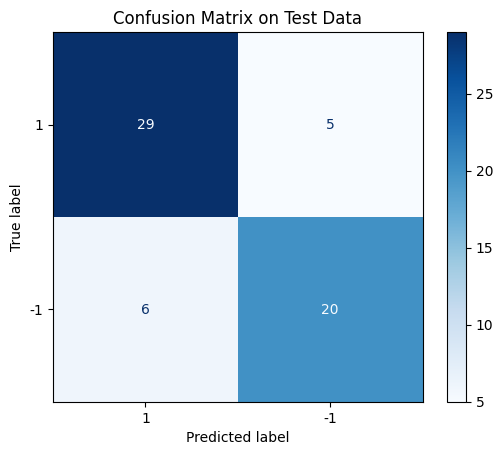

In [24]:
cm = confusion_matrix(y_test, test_preds, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, -1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()

In [25]:
print("\nClassification Report (Test Data):")
print(classification_report(y_test, test_preds, labels=[1, -1], digits=4))


Classification Report (Test Data):
              precision    recall  f1-score   support

           1     0.8286    0.8529    0.8406        34
          -1     0.8000    0.7692    0.7843        26

    accuracy                         0.8167        60
   macro avg     0.8143    0.8111    0.8124        60
weighted avg     0.8162    0.8167    0.8162        60



In [26]:
def plot_decision_boundary(weights):
    x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
    y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    Z = np.array([predict_label(x) for x in grid_points])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_data[Y_labels == 1][:, 0], X_data[Y_labels == 1][:, 1], color='red', label='Label +1')
    plt.scatter(X_data[Y_labels == -1][:, 0], X_data[Y_labels == -1][:, 1], color='blue', label='Label -1')
    plt.title("Decision Boundary of the Variational Circuit")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.legend()
    plt.show()

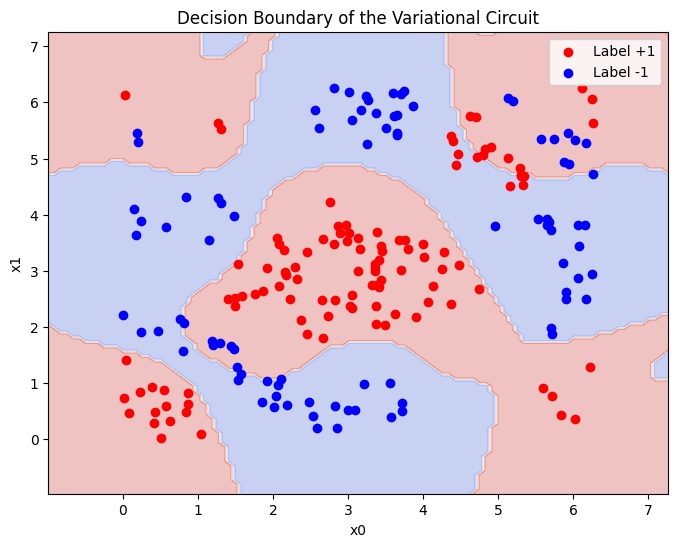

In [27]:
plot_decision_boundary(weights)